# **Market Regime Discovery**

> *What types of market behavior exist in historical financial data?*

**Objective**: Cluster the market into distinct behavioral regimes using returns, volatility, and drawdowns, instead of assuming markets behave the same every day.

# **Imports & Data Loading**

In [121]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import yfinance as yf


In [122]:
# S&P 500 historical data
df = yf.download("^GSPC", start="2000-01-01")

df.head(3)

/tmp/ipython-input-3936595352.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("^GSPC", start="2000-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2000-01-03,1455.219971,1478.000000,1438.359985,1469.250000,931800000
2000-01-04,1399.420044,1455.219971,1397.430054,1455.219971,1009000000
2000-01-05,1402.109985,1413.270020,1377.680054,1399.420044,1085500000


In [123]:
df.shape

(6561, 5)

In [124]:
df.columns

MultiIndex([( 'Close', '^GSPC'),
            (  'High', '^GSPC'),
            (   'Low', '^GSPC'),
            (  'Open', '^GSPC'),
            ('Volume', '^GSPC')],
           names=['Price', 'Ticker'])

In [125]:
# Fix MultiIndex columns from yfinance
df.columns = df.columns.get_level_values(0)

df.head(3)

Price,Close,High,Low,Open,Volume
Date,,,,,
2000-01-03,1455.219971,1478.000000,1438.359985,1469.250000,931800000
2000-01-04,1399.420044,1455.219971,1397.430054,1455.219971,1009000000
2000-01-05,1402.109985,1413.270020,1377.680054,1399.420044,1085500000


In [126]:
df.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')

# **Feature Engineering**
**(Market Behavior Signals)**

> *“How is the market behaving on a given day?”*



To describe behavior, we need signals that capture:

1. **Movement**: did price go up or down?

2. **Risk**: how unstable is the movement?

3. **Pain**: how bad is the loss compared to the past?

**Choose**: return, volatility, drawdown.

In [127]:
# Daily returns: direction & magnitude of movement

df['return'] = df['Close'].pct_change()

In [128]:
# Rolling volatility: short-term market risk

df['volatility'] = df['return'].rolling(window=14).std()

In [129]:
# Drawdown: distance from recent peak (market pain)

rolling_max = df['Close'].cummax()
df['drawdown'] = (df['Close'] - rolling_max) / rolling_max

In [130]:
# Drop NaNs

df = df.dropna()

In [131]:
df.shape

(6547, 8)

In [132]:
df[['return', 'volatility', 'drawdown']].head()

Price,return,volatility,drawdown
Date,,,
2000-01-24,-0.027634,0.016558,-0.043422
2000-01-25,0.006065,0.013057,-0.037621
2000-01-26,-0.004213,0.013113,-0.041675
2000-01-27,-0.003938,0.013156,-0.045449
2000-01-28,-0.027457,0.012524,-0.071658


# **Data Exploration**


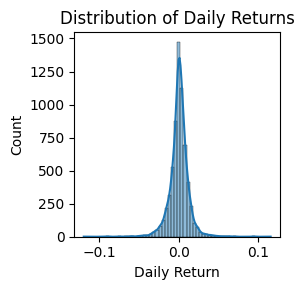

In [133]:
# DISTRIBUTION OF DAILY RETURNS

plt.figure(figsize=(3, 3))
sns.histplot(df['return'], bins=60, kde=True)
plt.title("Distribution of Daily Returns")
plt.xlabel("Daily Return")
plt.tight_layout()
plt.show()


### Returns Distribution

- Most daily returns are **close to zero**, with rare but extreme moves in the tails, showing that **large market shocks are infrequent**.

- The asymmetry highlights that **downside risk is not well captured by average returns alone**.

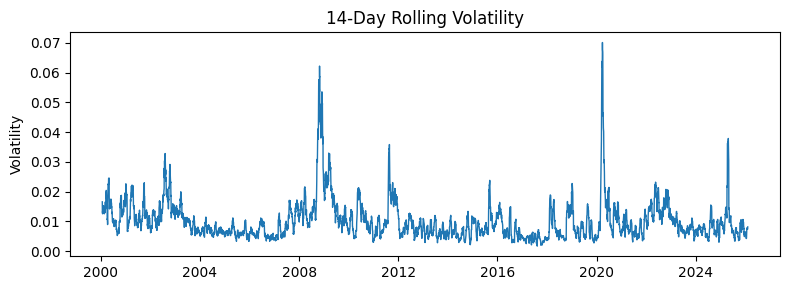

In [134]:
# ROLLING VOLATILITY OVER TIME

plt.figure(figsize=(8, 3))
plt.plot(df.index, df['volatility'], linewidth=1)
plt.title("14-Day Rolling Volatility")
plt.ylabel("Volatility")
plt.tight_layout()
plt.show()


### Rolling Volatility

- Volatility stays **low during stable periods** and **spikes sharply around stress events**, indicating rising uncertainty **before and during** market shocks.

- These spikes justify treating **high-volatility periods differently from normal market conditions**.

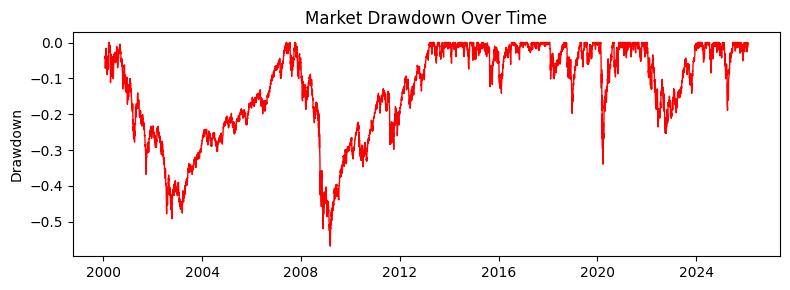

In [135]:
# MARKET DRAWDOWN OVER TIME

plt.figure(figsize=(8, 3))
plt.plot(df.index, df['drawdown'], color='red', linewidth=1)
plt.title("Market Drawdown Over Time")
plt.ylabel("Drawdown")
plt.tight_layout()
plt.show()


## Drawdown

- Drawdowns reveal **long and deep loss phases during crises**, not visible from returns alone.

- Extended drawdown periods indicate **sustained market stress rather than short-term noise**.

**Summary**

| Visualization                        | What It Shows                     | Key Interpretation                                                                                           |
| ------------------------------------ | --------------------------------- | ------------------------------------------------------------------------------------------------------------ |
| **Returns Distribution (Histogram)** | Frequency of daily market returns | Returns are centered around zero with fat tails, indicating mostly small moves but occasional extreme events |
| **Rolling Volatility (Line Plot)**   | Short-term risk over time         | Volatility spikes during market stress periods, confirming non-constant risk behavior                        |
| **Drawdown Curve (Line Plot)**       | Cumulative loss from peak         | Large and prolonged drawdowns reflect crisis periods where capital preservation matters                      |


# **Feature Scaling**

In [136]:
features = df[['return', 'volatility', 'drawdown']]

scaler = StandardScaler()
x_scaled = scaler.fit_transform(features)


In [137]:
x_scaled.shape

(6547, 3)

**Why Scaling?**
1. Volatility & drawdown dominate raw values
2. Scaling ensures all features contribute equally
3. Without this, regimes make no financial sense

# **KMeans Clustering (Regime Discovery)**

In [138]:
kmeans = KMeans(n_clusters=3, random_state=42)

df['regime'] = kmeans.fit_predict(x_scaled)


In [139]:
df['regime'].value_counts()

,count
regime,
1,4024
0,1863
2,660


# **Visualization 1: Market Regimes on Price Chart**

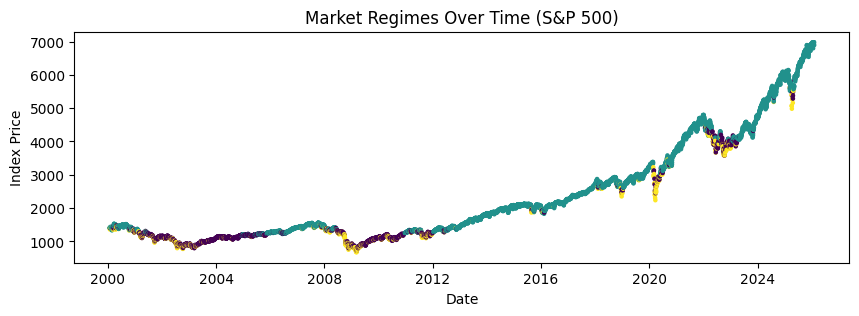

In [140]:
plt.figure(figsize=(10,3))
plt.scatter(df.index, df['Close'], c=df['regime'], cmap='viridis', s=5)
plt.title("Market Regimes Over Time (S&P 500)")
plt.xlabel("Date")
plt.ylabel("Index Price")
plt.show()


> “On THIS day, the market behaved like Regime X”



**Each dot**: One trading day



- Same-colored regions = **same market behavior**
- Sudden color changes = **regime shifts**
- Dark / clustered regions during crashes = **crisis regimes**

## **Regime Statistics (Validation)**

In [141]:
regime_summary = df.groupby('regime')[['return', 'volatility', 'drawdown']].mean()
regime_summary


Price,return,volatility,drawdown
regime,,,
0,0.007066,0.012317,-0.258264
1,0.000341,0.007595,-0.048544
2,-0.018917,0.020001,-0.266684


# **Overall Interpretation**

---

**Regime 0: Volatile / Sideways**

| Metric         | Value      | Meaning                                          |
| -------------- | ---------- | ------------------------------------------------ |
| Avg Return     | **+0.7%**  | Gains exist but are inconsistent                 |
| Avg Volatility | **1.23%**  | Elevated day-to-day risk                         |
| Avg Drawdown   | **−25.8%** | Large losses from peaks despite positive returns |

> *Positive returns combined with deep drawdowns show choppy, unstable markets, not suitable for long-term holding.*

---

**Regime 1: Calm / Bullish**

| Metric         | Value                 | Meaning                 |
| -------------- | --------------------- | ----------------------- |
| Avg Return     | **+0.03%**            | Small but steady gains  |
| Avg Volatility | **0.76%** *(lowest)*  | Stable risk environment |
| Avg Drawdown   | **−4.85%** *(lowest)* | Minimal capital erosion |

> *This regime offers the best risk-adjusted environment, ideal for long-term investing and trend-following strategies.*

---

**Regime 2: Crisis / High-Risk**

| Metric         | Value                 | Meaning                         |
| -------------- | --------------------- | ------------------------------- |
| Avg Return     | **−1.89%**            | Sustained negative performance  |
| Avg Volatility | **2.00%** *(highest)* | Extreme uncertainty             |
| Avg Drawdown   | **−26.7%**            | Severe losses from market peaks |

> *High volatility and deep drawdowns confirm market stress or crash periods, where capital preservation dominates*


# **Visualization 2: Volatility by Regime**

> To compare how market risk (volatility) behaves under different detected regimes.

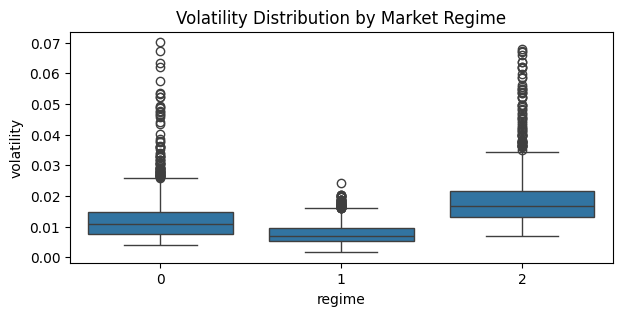

In [142]:
plt.figure(figsize=(7,3))
sns.boxplot(x='regime', y='volatility', data=df)
plt.title("Volatility Distribution by Market Regime")
plt.show()


**1. Regime 1 (Calm)**
- lowest and tightest volatility
- indicates stable market conditions.

**2. Regime 2 (Crisis)**
- highest median volatility
- extreme outliers
- confirms stress periods.

**3. Regime 0** sits in between
- represents uncertain or sideways markets

> *The clustering meaningfully separates markets by risk intensity, not just price direction.*

# **Visualization 3: Drawdown by Regime**

> To visually connect market pain (drawdowns) with detected regimes over time.

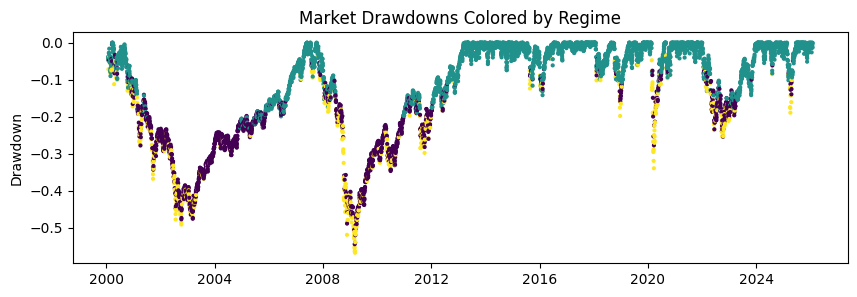

In [143]:
plt.figure(figsize=(10,3))
plt.scatter(df.index, df['drawdown'], c=df['regime'], cmap='viridis', s=4)
plt.title("Market Drawdowns Colored by Regime")
plt.ylabel("Drawdown")
plt.show()


- **Deep drawdowns consistently align with Regime 2**, validating it as a crisis/high-risk state.

- **Regime 1 dominates** near zero drawdown, reflecting recovery and bullish phases.

- **Regimes transition naturally rather than randomly**, matching real market cycles.

# **Save Outputs for Model2**



In [144]:
import os
os.makedirs("outputs", exist_ok=True)

# regime-labeled dataset

df[['return', 'volatility', 'drawdown', 'regime']].to_csv(
    "outputs/regimes.csv",
    index=True
)

df[['return', 'volatility', 'drawdown', 'regime']].to_json(
    "outputs/regimes.json",
    orient="records"
)

# **Conclusion**


- In this notebook, we identified **distinct market behavior regimes** using **unsupervised learning** on:
  1. **returns**
  2. **volatility**
  3. **drawdowns**


- The clustering reveals that **markets do not behave uniformly over time**, instead, they transition between: **calm, volatile, and crisis** states with clearly different risk characteristics.

- These regimes provide structural context for understanding:
  1. **when risk is building? **
  2. **when drawdowns are likely to deepen? **
  3. **when traditional ML models may become unreliable?**

The regime labels generated here form the foundation for downstream **risk prediction and model failure ** analysis in MSIS.